# Problem Description



The original dataset from the reference consists of 5 different folders, each with 100 files, with each file representing a single subject/person. Each file is a recording of brain activity for 23.6 seconds. The corresponding time-series is sampled into 4097 data points. Each data point is the value of the EEG recording at a different point in time. So we have total 500 individuals with each has 4097 data points for 23.5 seconds.

UCI divided and shuffled every 4097 data points into 23 chunks, each chunk contains 178 data points for 1 second, and each data point is the value of the EEG recording at a different point in time. So now we have 23 x 500 = 11500 pieces of information(row), each information contains 178 data points for 1 second(column), the last column represents the label y {1,2,3,4,5}.

The response variable is y in column 179, the Explanatory variables X1, X2, ..., X178

y contains the category of the 178-dimensional input vector. Specifically y in {1, 2, 3, 4, 5}:

5 - eyes open, means when they were recording the EEG signal of the brain the patient had their eyes open

4 - eyes closed, means when they were recording the EEG signal the patient had their eyes closed

3 - Yes they identify where the region of the tumor was in the brain and recording the EEG activity from the healthy brain area

2 - They recorder the EEG from the area where the tumor was located

1 - Recording of seizure activity

All subjects falling in classes 2, 3, 4, and 5 are subjects who did not have epileptic seizure. Only subjects in class 1 have epileptic seizure. Our motivation for creating this version of the data was to simplify access to the data via the creation of a .csv version of it. Although there are 5 classes most authors have done binary classification, namely class 1 (Epileptic seizure) against the rest.

### References
https://archive.ics.uci.edu/ml/datasets/Epileptic+Seizure+Recognition#

Andrzejak RG, Lehnertz K, Rieke C, Mormann F, David P, Elger CE (2001) Indications of nonlinear deterministic and finite dimensional structures in time series of brain electrical activity: Dependence on recording region and brain state, Phys. Rev. E, 64, 061907

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# Import packages
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import average_precision_score, classification_report, precision_recall_curve, precision_score, recall_score,roc_auc_score, confusion_matrix 

import xgboost as xgb
from xgboost.sklearn import XGBClassifier


# Enable display of up to 200 columns
pd.set_option('display.max_columns',200)
pd.set_option('display.max_rows',200)
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Read data and load into a pandas dataframe
data = pd.read_csv('data/data.csv'); data.head()

,Unnamed: 0,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,X11,X12,X13,X14,X15,X16,X17,X18,X19,X20,X21,X22,X23,X24,X25,X26,X27,X28,X29,X30,X31,X32,X33,X34,X35,X36,X37,X38,X39,X40,X41,X42,X43,X44,X45,X46,X47,X48,X49,X50,X51,X52,X53,X54,X55,X56,X57,X58,X59,X60,X61,X62,X63,X64,X65,X66,X67,X68,X69,X70,X71,X72,X73,X74,X75,X76,X77,X78,X79,X80,X81,X82,X83,X84,X85,X86,X87,X88,X89,X90,X91,X92,X93,X94,X95,X96,X97,X98,X99,X100,X101,X102,X103,X104,X105,X106,X107,X108,X109,X110,X111,X112,X113,X114,X115,X116,X117,X118,X119,X120,X121,X122,X123,X124,X125,X126,X127,X128,X129,X130,X131,X132,X133,X134,X135,X136,X137,X138,X139,X140,X141,X142,X143,X144,X145,X146,X147,X148,X149,X150,X151,X152,X153,X154,X155,X156,X157,X158,X159,X160,X161,X162,X163,X164,X165,X166,X167,X168,X169,X170,X171,X172,X173,X174,X175,X176,X177,X178,y
0,X21.V1.791,135,190,229,223,192,125,55,-9,-33,-38,-10,35,64,113,152,164,127,50,-47,-121,-138,-125,-101,-50,11,39,24,48,64,46,13,-19,-61,-96,-130,-132,-116,-115,-71,-14,25,19,6,9,21,13,-37,-58,-33,5,47,80,101,88,73,69,41,-13,-31,-61,-80,-77,-66,-43,5,87,129,121,88,12,-76,-150,-207,-186,-165,-148,-103,-33,40,94,75,8,-81,-155,-227,-262,-233,-218,-187,-126,-65,-12,27,61,49,9,-46,-124,-210,-281,-265,-181,-89,-4,53,53,38,43,31,34,9,-7,-34,-70,-84,-101,-70,-11,42,62,66,74,64,59,56,36,-11,-30,-43,-23,8,42,77,103,135,121,79,59,43,54,90,111,107,64,32,18,-25,-69,-65,-44,-33,-57,-88,-114,-130,-114,-83,-53,-79,-72,-85,-109,-98,-72,-65,-63,-11,10,8,-17,-15,-31,-77,-103,-127,-116,-83,-51,4
1,X15.V1.924,386,382,356,331,320,315,307,272,244,232,237,258,212,2,-267,-605,-850,-1001,-1109,-1090,-967,-746,-464,-152,118,318,427,473,485,447,397,339,312,314,326,335,332,324,310,312,309,309,303,297,295,295,293,286,279,283,301,308,285,252,215,194,169,111,-74,-388,-679,-892,-949,-972,-1001,-1006,-949,-847,-668,-432,-153,72,226,326,392,461,495,513,511,496,479,453,440,427,414,399,385,385,404,432,444,437,418,392,373,363,365,372,385,388,383,371,360,353,334,303,252,200,153,151,143,48,-206,-548,-859,-1067,-1069,-957,-780,-597,-460,-357,-276,-224,-210,-350,-930,-1413,-1716,-1360,-662,-96,243,323,241,29,-167,-228,-136,27,146,229,269,297,307,303,305,306,307,280,231,159,85,51,43,62,63,63,69,89,123,136,127,102,95,105,131,163,168,164,150,146,152,157,156,154,143,129,1
2,X8.V1.1,-32,-39,-47,-37,-32,-36,-57,-73,-85,-94,-99,-94,-96,-104,-103,-92,-75,-69,-69,-53,-37,-14,-10,-39,-78,-102,-98,-80,-54,-40,-35,-39,-32,-13,7,34,41,33,6,-15,-30,-47,-53,-65,-64,-68,-85,-98,-109,-82,-57,-38,-40,-36,-31,-13,11,19,9,-20,-48,-71,-71,-57,-32,-13,6,29,27,25,10,-7,-36,-47,-37,-36,-22,-32,-38,-55,-61,-64,-72,-67,-53,-25,-10,-4,-23,-55,-93,-102,-106,-101,-69,-45,-42,-57,-64,-77,-80,-77,-78,-56,-34,-5,10,5,-5,-44,-75,-99,-110,-104,-103,-94,-105,-108,-110,-99,-89,-82,-76,-80,-90,-106,-106,-108,-87,-60,-37,-26,-15,-6,-14,-23,-34,-41,-54,-82,-107,-126,-124,-108,-84,-68,-61,-56,-63,-62,-33,1,28,45,37,48,62,80,66,23,-11,-39,-44,-42,-45,-48,-42,-6,29,57,64,48,19,-12,-30,-35,-35,-36,5
3,X16.V1.60,-105,-101,-96,-92,-89,-95,-102,-100,-87,-79,-72,-68,-74,-80,-83,-73,-68,-61,-58,-59,-64,-79,-84,-97,-94,-84,-77,-75,-72,-68,-76,-76,-72,-67,-69,-69,-69,-67,-68,-69,-67,-66,-58,-54,-56,-70,-80,-82,-85,-74,-70,-71,-82,-88,-93,-97,-89,-87,-83,-70,-50,-37,-31,-32,-39,-54,-64,-68,-67,-69,-63,-60,-63,-55,-43,-37,-27,-31,-35,-47,-58,-63,-74,-73,-67,-60,-56,-49,-46,-57,-58,-62,-63,-63,-61,-56,-65,-62,-57,-61,-63,-66,-69,-86,-89,-86,-83,-87,-80,-69,-62,-57,-60,-60,-68,-58,-53,-57,-66,-66,-73,-78,-73,-84,-92,-97,-88,-81,-72,-61,-66,-72,-88,-90,-88,-77,-58,-53,-61,-69,-66,-74,-69,-61,-51,-45,-45,-49,-58,-64,-78,-80,-90,-87,-83,-78,-64,-38,-22,-29,-42,-51,-68,-71,-69,-69,-74,-74,-80,-82,-81,-80,-77,-85,-77,-72,-69,-65,5
4,X20.V1.54,-9,-65,-98,-102,-78,-48,-16,0,-21,-59,-90,-103,-84,-43,-9,3,-21,-60,-96,-103,-75,-29,14,55,78,73,28,-13,-43,-68,-78,-75,-55,-41,-19,-20,-29,-36,-20,1,16,14,-14,-42,-56,-45,-45,-45,-38,-47,-45,-37,-3,23,39,27,0,-28,-44,-37,-22,5,30,31,6,-32,-27,-27,2,13,-6,-29,-41,-22,-13,-16,-31,-52,-60,-40,-16,0,14,24,36,3

In [4]:
# Remove ID column and set response variable y to binary, where 1 corresponds to positive for epilepsy case 
# and 0 to negative
data_id = data.iloc[:,0]
data.drop('Unnamed: 0', axis = 1, inplace = True)
data.y = data.y == 1

In [5]:

def check_missing(dataset, display = 5):
    temp_df = dataset.copy()
    df_nan = (temp_df.isnull().sum() / len(temp_df)) * 100
    missing_data = pd.DataFrame({'Missing n': temp_df.isnull().sum(),'% Missing' :df_nan})
    if missing_data['Missing n'].sum() == 0:
        return print('Great! There are no missing values in this dataset.')
    else:
        return missing_data.sort_values('% Missing', ascending = False).head(display)
    
    # Function to check the output variable
def check_output(dataset, output):
    amount = dataset[output].value_counts()
    ratio =  dataset[output].value_counts(normalize = True)*100
    print('Class 0: {} ({}%)'.format(amount[0], round(ratio[0],2)))
    print('Class 1: {} ({}%)'.format(amount[1], round(ratio[1],2)))

    labels = ['1' if label == 1 else '0' for label in dataset[output]]
    palette = {'1': '#f56b69', '0': '#3bbbb3'}

    ax = sns.countplot(labels, palette=palette)
    plt.title(output)
    plt.ylabel('amount')
    return plt.show()

def scale_and_normalize(X, scaler_x, exception_list= None, y= None, scaler_y= None, transform_y = False, train_or_test = 'train'):
    '''
    scaler_x = StandardScaler()
    scaler_y = StandardScaler()

    rscaler_x = RobustScaler()
    rscaler_y = RobustScaler()

    jtrans_x = PowerTransformer(method='yeo-johnson')
    jtrans_y = PowerTransformer(method='yeo-johnson')

    boxcox_x = PowerTransformer(method='box-cox')
    boxcox_y = PowerTransformer(method='box-cox')

    qt_x = QuantileTransformer(output_distribution='normal')
    qt_y = QuantileTransformer(output_distribution='normal')
    '''
    
    temp_X = X.copy()
    scaled_y = y.copy()
    
    # Select features that will be transformed
    select = [c for c in temp_X.columns if c not in exception_list]
    temp_X_partial = temp_X[select]
    
    if train_or_test == 'train':
        # Fit and Transform in X - Train
        df_normalized = pd.DataFrame(scaler_x.fit_transform(temp_X_partial))
        df_normalized.columns = select
        temp_X[select] = df_normalized
        print('Fit and transform X - train done')
    
        if (y is not None) and (transform_y == True):
            # Fit and Transform in Y - Train
            scaled_y = pd.DataFrame(scaler_y.fit_transform(np.array(y).reshape(-1, 1)))
            print('Fit and transform y - train done')
    
    if (train_or_test == 'test') or (train_or_test == 'val') :
        # Transform X - Test
        df_normalized = pd.DataFrame(scaler_x.transform(temp_X_partial))
        df_normalized.columns = select
        temp_X[select] = df_normalized
        print('Transform X - test done')
    
        if (y is not None) and (transform_y == True):
            # Transform Y - Test
            scaled_y = pd.DataFrame(scaler_y.transform(np.array(y).reshape(-1, 1)))
            print('Transform y - test done')
    
    return temp_X, scaled_y, scaler_x, scaler_y

From now on we are are dealing with a classification problem, so let's check if our dataset has missing values that requires treatment and also check how the response variable is distributed

Great! There are no missing values in this dataset.
Class 0: 9200 (80.0%)
Class 1: 2300 (20.0%)


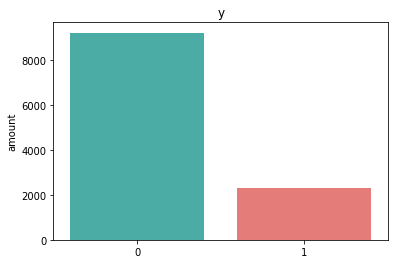

In [6]:
check_missing(data)
check_output(data, 'y')

Let's check some statistics

In [7]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
X1,11500.0,-11.581391,165.626284,-1839.0,-54.00,-8.0,34.00,1726.0
X2,11500.0,-10.911565,166.059609,-1838.0,-55.00,-8.0,35.00,1713.0
X3,11500.0,-10.187130,163.524317,-1835.0,-54.00,-7.0,36.00,1697.0
X4,11500.0,-9.143043,161.269041,-1845.0,-54.00,-8.0,36.00,1612.0
X5,11500.0,-8.009739,160.998007,-1791.0,-54.00,-8.0,35.00,1518.0
X6,11500.0,-7.003478,161.328725,-1757.0,-54.00,-8.0,36.00,1816.0
X7,11500.0,-6.502087,161.467837,-1832.0,-54.00,-8.0,35.00,2047.0
X8,11500.0,-6.687130,162.119120,-1778.0,-55.00,-8.0,36.00,2047.0
X9,11500.0,-6.558000,162.033360,-1840.0,-55.00,-7.0,36.00,2047.0
X10,11500.0,-6.168435,160.436352,-1867.0,-54.00,-7.0,35.25,2047.0


Here we will prepare our dataset to test some models

In [8]:
# Define features and output variable
features = [col for col in data.columns if col not in ['y']]
X = data[features]
y = data.y

# Scale our data
scaler_x = StandardScaler()
X_scaled, _, _, _  = scale_and_normalize(X, scaler_x, exception_list= ['y'], y= y, scaler_y= None, transform_y = False, train_or_test = 'train')

# Split into train and tesf
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size = 0.20, random_state = 42, stratify = y)

Fit and transform X - train done


## Modelling

In [ ]:
from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform
            

param_test ={'num_leaves': sp_randint(6, 50), 
             'min_child_samples': sp_randint(100, 500), 
             'min_child_weight': [1e-5, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4],
             'subsample': sp_uniform(loc=0.2, scale=0.8), 
             'colsample_bytree': sp_uniform(loc=0.4, scale=0.6),
             'reg_alpha': [0, 1e-1, 1, 2, 5, 7, 10, 50, 100],
             'reg_lambda': [0, 1e-1, 1, 5, 10, 20, 50, 100]}

In [ ]:
n_iterations = 100

from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

clf = XGBClassifier(max_depth=5, # cant be -1
                         random_state=42, 
                         silent=True, 
                         metric='roc_auc', 
                         n_estimators=1000)

gs = RandomizedSearchCV(
    estimator=clf, 
    param_distributions=param_test, 
    n_iter=n_iterations,
    scoring='roc_auc',
    cv=5,
    refit=True,
    random_state=42,
    n_jobs=-1, #set parallelism in CPU
    verbose=True)

gs.fit(X_train, y_train)#, **fit_params)
print('Best score reached: {} with params: {} '.format(gs.best_score_, gs.best_params_))

In [ ]:
#set optimal parameters
clf_sw = XGBClassifier(**clf.get_params())
clf_sw.set_params(**gs.best_params_)
clf_sw

In [ ]:
gs_sample_weight = GridSearchCV(estimator=clf_sw, 
                                param_grid={'scale_pos_weight':[1,2,6,12]},
                                scoring='neg_log_loss',
                                cv=5,
                                refit=True,
                                n_jobs=-1,
                                verbose=True)

In [ ]:
gs_sample_weight.fit(X_train, y_train)
print('Best score reached: {} with params: {} '.format(gs_sample_weight.best_score_, gs_sample_weight.best_params_))

In [21]:
%%time
import lightgbm as lgb
from sklearn.model_selection import KFold,StratifiedKFold,RepeatedKFold

param = {
    'boosting_type':'gbdt',
    'learning_rate' : 0.1, 
    'n_estimators' : 1000, 
    'max_depth' : 5,
    'min_child_samples':485,
    'min_child_weight' : 1e-5,
    'gamma' : 0, 
    'subsample' : 0.7619872671896875,
    'colsample_bytree' : 0.710997791418242,
    'reg_alpha' : 0,
    'num_leaves':45,
    'reg_lambda':0,
    'objective' : 'binary', 
    'n_jobs' : -1,
    'scale_pos_weight' : 1, 
    'seed' : 42,
    'metric':'auc'
}


kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
oof = np.zeros(len(X_train))
predictions = np.zeros(len(X_test))
feature_importance_df = pd.DataFrame()

for fold_, (trn_idx, val_idx) in enumerate(kfold.split(X_train, y_train)):


    print("fold {}".format(fold_ + 1))
    trn_data = lgb.Dataset(X_train.iloc[trn_idx],
                           label=y_train.iloc[trn_idx]
                          )
    val_data = lgb.Dataset(X_train.iloc[val_idx],
                           label=y_train.iloc[val_idx]
                          )

    num_round = 100
    clf = lgb.train(param,
                    trn_data,
                    num_round,
                    valid_sets = [trn_data, val_data],
                    valid_names = ['train','eval'], 
                    verbose_eval=100,
                    early_stopping_rounds = 100)
    
    oof[val_idx] = clf.predict(X_train.iloc[val_idx], num_iteration=clf.best_iteration)
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = features
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = fold_ + 1 
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    
    predictions += clf.predict(X_test, num_iteration=clf.best_iteration) / kfold.n_splits

print("CV score: {:<8.5f}".format(roc_auc_score(y_train, oof)))



fold 1
Training until validation scores don't improve for 100 rounds
[100]	train's auc: 0.997517	eval's auc: 0.993203
[200]	train's auc: 0.999767	eval's auc: 0.99388
[300]	train's auc: 0.999995	eval's auc: 0.994154
[400]	train's auc: 1	eval's auc: 0.994154
Early stopping, best iteration is:
[386]	train's auc: 1	eval's auc: 0.994216
fold 2
Training until validation scores don't improve for 100 rounds
[100]	train's auc: 0.997538	eval's auc: 0.99038
[200]	train's auc: 0.99985	eval's auc: 0.992791
[300]	train's auc: 0.999999	eval's auc: 0.992978
[400]	train's auc: 1	eval's auc: 0.993284
[500]	train's auc: 1	eval's auc: 0.993681
[600]	train's auc: 1	eval's auc: 0.993624
Early stopping, best iteration is:
[515]	train's auc: 1	eval's auc: 0.993795
fold 3
Training until validation scores don't improve for 100 rounds
[100]	train's auc: 0.997556	eval's auc: 0.993384
[200]	train's auc: 0.999757	eval's auc: 0.994916
[300]	train's auc: 0.999995	eval's auc: 0.995328
[400]	train's auc: 1	eval's auc: 

In [ ]:
# Load saved model
clf = pickle.load(open('model.pkl', 'rb' ))

In [22]:
# Save model
pickle.dump(clf, open('model.pkl', 'wb'), protocol = 4)

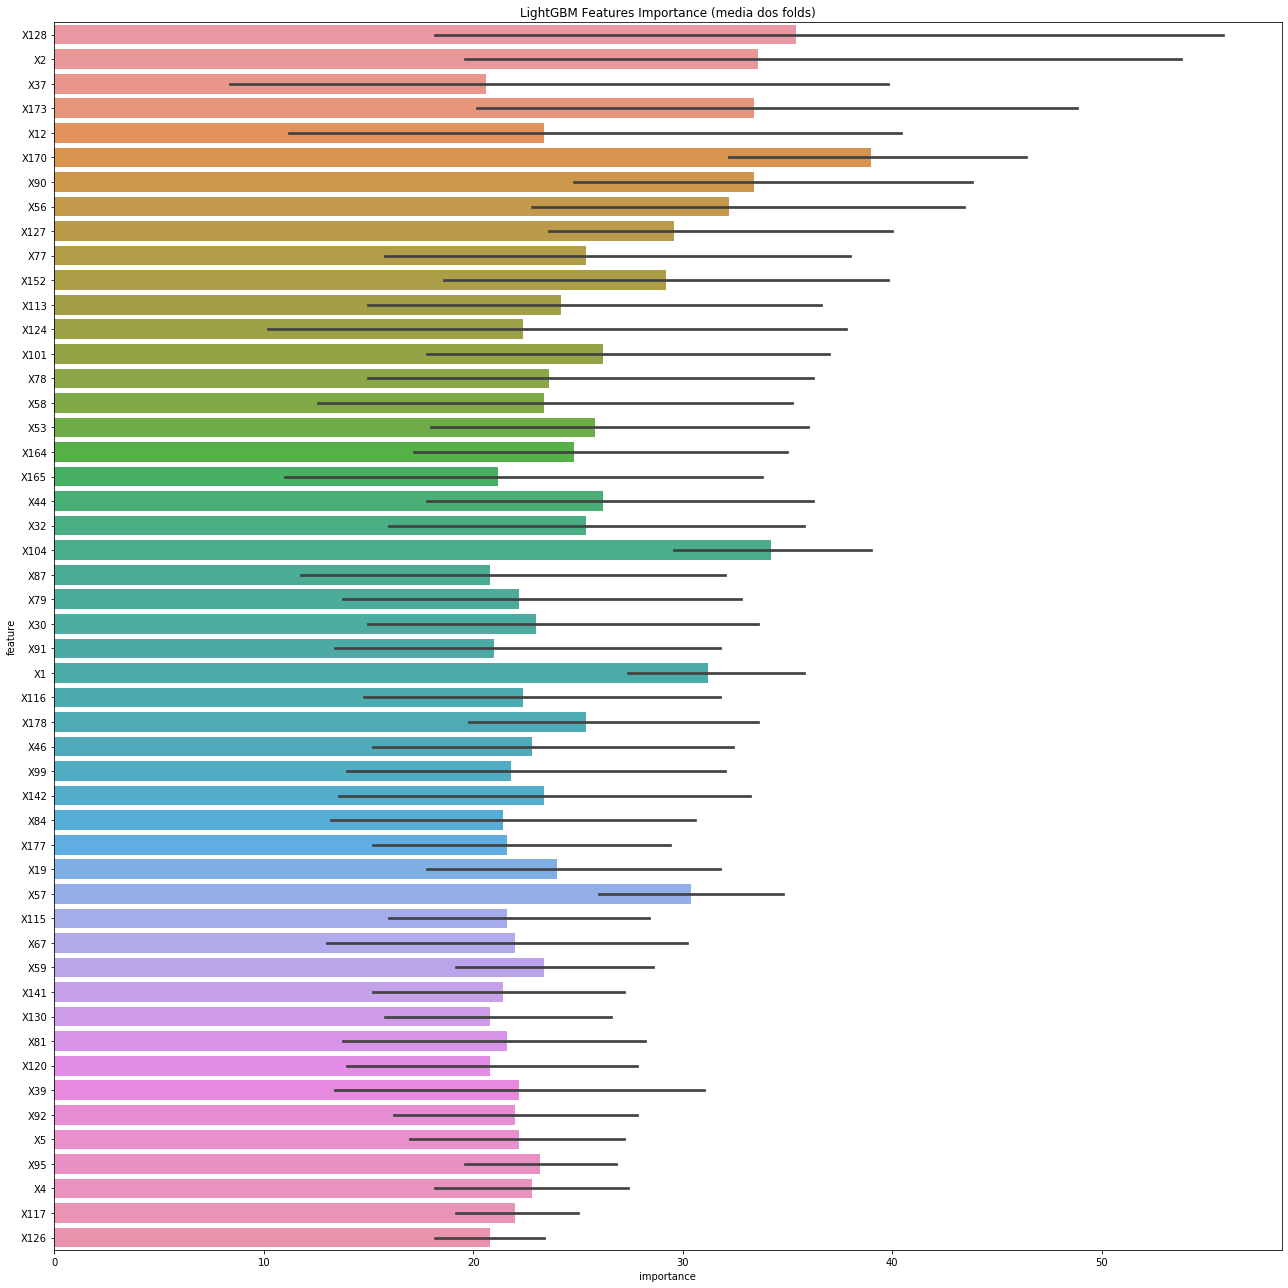

In [18]:
cols = (feature_importance_df[["feature", "importance"]]
        .groupby("feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:50].index)
best_features = feature_importance_df.loc[feature_importance_df.feature.isin(cols)]

plt.figure(figsize=(18,18))
sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance",ascending=False))
plt.title('LightGBM Features Importance (media dos folds)')
plt.tight_layout()

In [23]:
y_pred_final = np.round(clf.predict(X_test[features]))
y_true_final = np.array(y_test)

# Calculates roc
roc = roc_auc_score(y_true_final, y_pred_final)

print('Average ROC AUC on new dataset: {0:0.4f}\n'.format(roc))

print('Confustion Matrix: \n{}'.format(confusion_matrix(y_true_final, y_pred_final)))



print('\nClassification Report: \n\n {}' .format(classification_report(y_true_final, y_pred_final)))

Average ROC AUC on new dataset: 0.9440

Confustion Matrix: 
[[1822   18]
 [  47  413]]

Classification Report: 

              precision    recall  f1-score   support

      False       0.97      0.99      0.98      1840
       True       0.96      0.90      0.93       460

avg / total       0.97      0.97      0.97      2300

